In [1]:
import os
import numpy as np
import cv2
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import flatten, sum
from tensorflow.keras.losses import binary_crossentropy

In [2]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f)
    score = (2. * intersection + smooth) / (union + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss

In [3]:
# Loading the model
model = load_model(
    filepath=os.path.abspath('../models/segmentation/skullnet.h5'), 
    custom_objects={
        'dice_coef': dice_coef, 
        'iou_coef': iou_coef, 
        'bce_dice_loss': bce_dice_loss
    }
)

In [4]:
def plot_skull_stripping(test_image):
    def preprocess_image(image_path, target_size=(128, 128)):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, target_size)  
        image = np.expand_dims(image, axis=-1)  # Add channel dimension (H, W, 1)
        image = np.expand_dims(image, axis=0)  # Add batch dimension (1, H, W, 1)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        return image
    
    # Load and preprocess the image
    image = preprocess_image(test_image)
    
    # Predict the mask using the trained model
    predicted_mask = model.predict(image)
    
    # Squeeze the predicted mask to remove extra dimensions
    predicted_mask = np.squeeze(predicted_mask)
    
    # Step 1: Threshold the predicted mask (to create a binary mask)
    threshold_value = 0.5
    binary_mask = (predicted_mask > threshold_value).astype(np.float32)
    
    # Step 2: Load the original image (grayscale)
    original_image = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
    
    # Resize the original image to the same size as the predicted mask
    if original_image.shape != binary_mask.shape:
        original_image = cv2.resize(original_image, (binary_mask.shape[1], binary_mask.shape[0]))
    
    # Step 3: Apply the mask (black out the background, keep the masked region)
    masked_image = original_image * binary_mask
    
    # Step 5: Display the results
    plt.figure(figsize=(6, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(masked_image, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

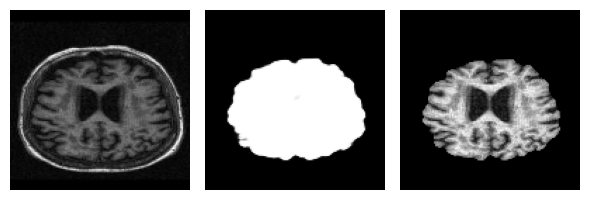

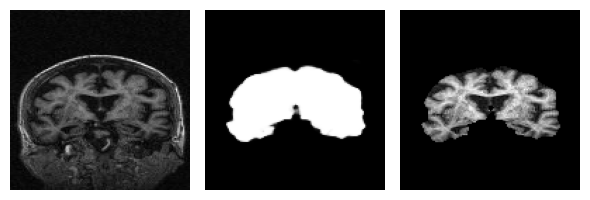

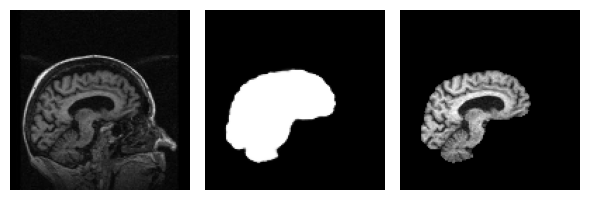

In [5]:
plot_skull_stripping(os.path.abspath('../datasets/OASIS-2/preprocessed_balanced/train/axial/moderate_dementia/OAS2_0087_MR2_mpr-1_axial_slice_30.jpg'))
plot_skull_stripping(os.path.abspath('../datasets/OASIS-2/preprocessed_balanced/train/coronal/moderate_dementia/OAS2_0087_MR2_mpr-1_coronal_slice_30.jpg'))
plot_skull_stripping(os.path.abspath('../datasets/OASIS-2/preprocessed_balanced/train/sagittal/moderate_dementia/OAS2_0087_MR2_mpr-1_sagittal_slice_30.jpg'))

## Export 

In [6]:
def skull_stripping(test_image, output_path, view='axial'):
    def preprocess_image(image_path, target_size=(128, 128)):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, target_size)  
        image = np.expand_dims(image, axis=-1)  # Add channel dimension (H, W, 1)
        image = np.expand_dims(image, axis=0)  # Add batch dimension (1, H, W, 1)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        return image
    
    # Load and preprocess the image
    image = preprocess_image(test_image)
    
    # Predict the mask using the trained model
    predicted_mask = model.predict(image)
    
    # Squeeze the predicted mask to remove extra dimensions
    predicted_mask = np.squeeze(predicted_mask)
    
    # Threshold the predicted mask (to create a binary mask)
    threshold_value = 0.5
    binary_mask = (predicted_mask > threshold_value).astype(np.float32)
    
    # Load the original image (grayscale)
    original_image = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
    
    # Resize the original image to the same size as the predicted mask
    if original_image.shape != binary_mask.shape:
        original_image = cv2.resize(original_image, (binary_mask.shape[1], binary_mask.shape[0]))
    
    # Apply the mask (black out the background, keep the masked region)
    masked_image = original_image * binary_mask
    
    # Save the masked image to the specified output path
    cv2.imwrite(output_path, masked_image)

In [7]:
def process_images(input_folder, output_folder, view):
    os.makedirs(output_folder, exist_ok=True)

    # Gather all image files
    image_files = []
    for subdir, _, files in os.walk(os.path.join(input_folder, view)):
        for file in files:
            if file.lower().endswith(('.jpg', '.png')):
                image_files.append(os.path.join(subdir, file))

    # Split the path into parts and remove the last part
    path_parts = output_folder.split(os.sep)
    output_folder = os.sep.join(path_parts[:-1])

    # Process each image with a progress bar
    for input_image_path in tqdm(image_files, desc=f'Processing {view} view', unit='image'):
        relative_path = os.path.relpath(os.path.dirname(input_image_path), input_folder)
        output_subfolder = os.path.join(output_folder, relative_path)
        os.makedirs(output_subfolder, exist_ok=True)

        output_image_path = os.path.join(output_subfolder, f"{os.path.splitext(os.path.basename(input_image_path))[0]}_masked.jpg")

        # Call the skull stripping function
        skull_stripping(input_image_path, output_image_path, view)

## Train

In [8]:
input_folder = r'D:\Research\Vision\mra\root\datasets\OASIS-2\preprocessed_balanced\train'
output_folder = r'D:\Research\Vision\mra\root\datasets\OASIS-2\preprocessed_balanced_ss\train'

In [9]:
view_output_folder = os.path.join(output_folder, 'axial')
process_images(input_folder, view_output_folder, 'axial')

Processing axial view: 100%|████████████████████████████████████████████████████████████████████████████| 1594/1594 [01:31<00:00, 17.51image/s]


In [10]:
view_output_folder = os.path.join(output_folder, 'coronal')
process_images(input_folder, view_output_folder, 'coronal')

Processing coronal view: 100%|██████████████████████████████████████████████████████████████████████████| 1588/1588 [01:30<00:00, 17.57image/s]


In [11]:
view_output_folder = os.path.join(output_folder, 'sagittal')
process_images(input_folder, view_output_folder, 'sagittal')

Processing sagittal view: 100%|█████████████████████████████████████████████████████████████████████████| 1590/1590 [01:31<00:00, 17.29image/s]


## Test

In [12]:
input_folder = r'D:\Research\Vision\mra\root\datasets\OASIS-2\preprocessed_balanced\test'
output_folder = r'D:\Research\Vision\mra\root\datasets\OASIS-2\preprocessed_balanced_ss\test'

In [13]:
view_output_folder = os.path.join(output_folder, 'axial')
process_images(input_folder, view_output_folder, 'axial')

Processing axial view: 100%|██████████████████████████████████████████████████████████████████████████████| 657/657 [00:35<00:00, 18.67image/s]


In [14]:
view_output_folder = os.path.join(output_folder, 'coronal')
process_images(input_folder, view_output_folder, 'coronal')

Processing coronal view: 100%|████████████████████████████████████████████████████████████████████████████| 558/558 [00:30<00:00, 18.42image/s]


In [15]:
view_output_folder = os.path.join(output_folder, 'sagittal')
process_images(input_folder, view_output_folder, 'sagittal')

Processing sagittal view: 100%|███████████████████████████████████████████████████████████████████████████| 477/477 [00:26<00:00, 18.29image/s]


## Quality Control

In [16]:
def is_black(image_path, area_threshold, black_threshold=10):
    # Load the image (grayscale for simplicity)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return False  # In case the image is not found
    
    # Count the number of pixels that are close to black (pixel value < black_threshold)
    black_pixels = np.sum(img < black_threshold)
    
    # Calculate the fraction of black pixels in the image
    black_fraction = black_pixels / img.size
    
    # If the fraction of black pixels is greater than the threshold, consider it mostly black
    if black_fraction > area_threshold:
        # Print out image value statistics for debugging
        print(f"Total pixels: {img.size}, Black pixels: {black_pixels}")
        print(f"Black fraction: {black_fraction:.4f}, Threshold: {area_threshold:.2f}")
        return True
    
    return False

In [17]:
def delete_black_images(folder_path, area_threshold):
    """
    Deletes images that are mostly black or have very little segmentation, with a progress bar.
    """
    # Get the list of all files in the folder
    files = [filename for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))]
    
    for filename in files:
        image_path = os.path.join(folder_path, filename)
        
        if is_black(image_path, area_threshold):
            print(f"Deleting {filename} because it is mostly black or has minimal segmentation.")
            os.remove(image_path)  # Delete the image

In [18]:
views = ['axial', 'coronal', 'sagittal']
conditions = ['moderate_dementia', 'nondemented']
area_thresholds = {'sagittal': 0.90, 'axial': 0.80, 'coronal': 0.85}

In [19]:
# train 
for view in views:
    for condition in conditions:
        path = f'D:/Research/Vision/mra/root/datasets/OASIS-2/preprocessed_balanced_ss/train/{view}/{condition}'
        delete_black_images(path, area_threshold=area_thresholds.get(view))

Total pixels: 16384, Black pixels: 13374
Black fraction: 0.8163, Threshold: 0.80
Deleting coronal_synthetic_127_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 14511
Black fraction: 0.8857, Threshold: 0.80
Deleting coronal_synthetic_131_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 14383
Black fraction: 0.8779, Threshold: 0.80
Deleting coronal_synthetic_135_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 13403
Black fraction: 0.8181, Threshold: 0.80
Deleting coronal_synthetic_16_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 13825
Black fraction: 0.8438, Threshold: 0.80
Deleting coronal_synthetic_22_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 14643
Black fraction: 0.8937, Threshold: 0.80
Deleting coronal_synthetic

In [20]:
# test 
for view in views:
    for condition in conditions:
        path = f'D:/Research/Vision/mra/root/datasets/OASIS-2/preprocessed_balanced_ss/test/{view}/{condition}'
        delete_black_images(path, area_threshold=area_thresholds.get(view))

Total pixels: 16384, Black pixels: 13879
Black fraction: 0.8471, Threshold: 0.80
Deleting OAS2_0087_MR2_mpr-1_axial_slice_58_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 13575
Black fraction: 0.8286, Threshold: 0.80
Deleting OAS2_0087_MR2_mpr-2_axial_slice_56_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 13798
Black fraction: 0.8422, Threshold: 0.80
Deleting OAS2_0087_MR2_mpr-2_axial_slice_58_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 14656
Black fraction: 0.8945, Threshold: 0.80
Deleting OAS2_0087_MR2_mpr-3_axial_slice_63_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 14909
Black fraction: 0.9100, Threshold: 0.80
Deleting OAS2_0120_MR2_mpr-1_axial_slice_0_masked.jpg because it is mostly black or has minimal segmentation.
Total pixels: 16384, Black pixels: 13135


## 3-Plane

In [21]:
def copy_images(src_base, dst_base):
    # Categories to process
    categories = ['moderate_dementia', 'nondemented']
    
    # Views to process
    views = ['axial', 'coronal', 'sagittal']

    # Iterate over each category and create destination folders
    for category in categories:
        # Create destination folder for the category inside "3-plane"
        category_dst = os.path.join(dst_base, category)
        if not os.path.exists(category_dst):
            os.makedirs(category_dst)
        
        # Iterate over each view (axial, coronal, sagittal)
        for view in views:
            view_src = os.path.join(src_base, view, category)
            if os.path.exists(view_src):
                # Iterate over all files in the view folder
                for filename in os.listdir(view_src):
                    file_path = os.path.join(view_src, filename)
                    if os.path.isfile(file_path):
                        # Move each image to the new category folder
                        shutil.copy(file_path, os.path.join(category_dst, filename))

In [22]:
# Paths for train and test datasets
paths = [
    r'D:\Research\Vision\mra\root\datasets\OASIS-2\preprocessed_balanced_ss\train',
    r'D:\Research\Vision\mra\root\datasets\OASIS-2\preprocessed_balanced_ss\test'
]

# Copy images for each path
for path in paths:
    copy_images(path, os.path.join(path, '3-plane'))

print("Images have been successfully moved to the '3-plane' folders.")

Images have been successfully moved to the '3-plane' folders.
